In [5]:
import os
from pathlib import Path
import gzip
import json

from pymatgen.core import Structure
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_distances, paired_cosine_distances
from pymatgen.core import Structure
from matminer.featurizers.structure.sites import CrystalNNFingerprint

import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [26]:
structure_dir = Path('/projects/rlmolecule/jlaw/crystal-gnn-fork/inputs/structures')

def get_structures(filename):
    with gzip.open(Path(structure_dir, filename), 'r') as f:
        for key, structure_dict in tqdm(json.loads(f.read().decode()).items()):
            yield {'id': key, 'structure': Structure.from_dict(structure_dict)}
            
battery_structures_relaxed = pd.DataFrame(get_structures('battery_relaxed_structures.json.gz'))
icsd_structures = pd.DataFrame(get_structures('icsd_structures.json.gz'))
battery_structures_relaxed['composition'] = battery_structures_relaxed['id'].str.split('_').apply(lambda x: x[0])
battery_structures_relaxed['sg'] = battery_structures_relaxed.id.str.extract('sg(\d{1,3})').astype(int)

calc_energy = pd.read_csv('/projects/rlmolecule/jlaw/crystal-gnn-fork/inputs/structures/battery_relaxed_energies.csv')

  0%|          | 0/16445 [00:00<?, ?it/s]

In [3]:
battery_structures_relaxed['volume'] = battery_structures_relaxed.structure.apply(lambda x: x.volume / x.num_sites)  
battery_structures_relaxed['scaled_volume'] = battery_structures_relaxed.volume / 10
battery_structures_relaxed['energy'] = calc_energy.set_index('id').loc[battery_structures_relaxed.id].energyperatom.values

In [34]:
battery_fingerprints = pd.read_parquet('/projects/rlmolecule/pstjohn/crystal_fingerprints/battery_fingerprints_no_chem.parquet').dropna()
battery_fingerprints['icsd'] = battery_fingerprints.id.str.extract('(icsd_\d{6})')[0]

df_icsd_proto = battery_fingerprints[battery_fingerprints.type == 'icsd'].copy()
df_icsd_proto['composition_type'] = df_icsd_proto.id.str.split('|').apply(lambda x: x[0])\
    .str.split('_').apply(lambda x: tuple((int(i) for i in x[1:])))

battery_unrelaxed = battery_fingerprints[battery_fingerprints.type == 'unrelaxed']
battery_relaxed = battery_fingerprints[battery_fingerprints.type == 'relaxed'].copy()

In [9]:
df_icsd_proto.head(2)

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,id,type,icsd,composition_type
0,0.357694,0.291032,0.357694,0.291032,0.323488,0.274923,0.03359,0.08443,0.108343,0.210750,...,0.0,0.0,0.0,0.0,0.0,0.0,_1_1_1_2_3|orthorhombic|POSCAR_sg62_icsd_174512,icsd,icsd_174512,"(1, 1, 1, 2, 3)"
1,0.236825,0.267743,0.236825,0.267743,0.058103,0.047493,0.00488,0.00832,0.022488,0.030999,...,0.0,0.0,0.0,0.0,0.0,0.0,_1_1_1_2_3|orthorhombic|POSCAR_sg70_icsd_079945,icsd,icsd_079945,"(1, 1, 1, 2, 3)"


In [11]:
import re
def extract_comp_type(comp):
    # split by the digits
    # e.g., for "Li1Sc1F4": ['Li', '1', 'Sc', '1', 'F', '4', '']
    split = np.asarray(re.split('(\d+)', comp))
    comp_type = tuple(sorted(map(int, split[range(1, len(split), 2)])))
    return comp_type
extract_comp_type("F4Li1Sc1")

(1, 1, 4)

In [36]:
battery_relaxed['composition'] = battery_relaxed.id.str.split('_').apply(lambda x: x[0])
battery_relaxed['composition_type'] = battery_relaxed.composition.apply(extract_comp_type)
battery_relaxed.head(2)

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,id,type,icsd,composition,composition_type
4170,0.233125,0.249362,0.233125,0.249362,0.103142,0.123302,0.042751,0.068929,0.048339,0.065723,...,0.0,0.0,0.0,0.0,0.0,Na1Cd1Si1Cl4P1_sg11_icsd_065346_3,relaxed,icsd_065346,Na1Cd1Si1Cl4P1,"(1, 1, 1, 1, 4)"
4171,0.201718,0.190068,0.201718,0.190068,0.234840,0.271078,0.088184,0.159498,0.105297,0.194897,...,0.0,0.0,0.0,0.0,0.0,Na2Hg1Si1O1N2_sg14_icsd_170588_4,relaxed,icsd_170588,Na2Hg1Si1O1N2,"(1, 1, 1, 2, 2)"


In [150]:
df_proto_and_relaxed['composition_type'].nunique()

72

In [151]:
battery_relaxed['composition_type'].nunique()

64

In [37]:
df_proto_and_relaxed = pd.concat([df_icsd_proto, battery_relaxed])
df_proto_and_relaxed.head(2)

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,id,type,icsd,composition_type,composition
0,0.357694,0.291032,0.357694,0.291032,0.323488,0.274923,0.03359,0.08443,0.108343,0.210750,...,0.0,0.0,0.0,0.0,0.0,_1_1_1_2_3|orthorhombic|POSCAR_sg62_icsd_174512,icsd,icsd_174512,"(1, 1, 1, 2, 3)",NaN
1,0.236825,0.267743,0.236825,0.267743,0.058103,0.047493,0.00488,0.00832,0.022488,0.030999,...,0.0,0.0,0.0,0.0,0.0,_1_1_1_2_3|orthorhombic|POSCAR_sg70_icsd_079945,icsd,icsd_079945,"(1, 1, 1, 2, 3)",NaN


In [38]:
df_proto_and_relaxed.tail(2)

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,id,type,icsd,composition_type,composition
72008,0.033869,0.022807,0.033869,0.022807,0.080459,0.083284,0.040617,0.080162,0.039654,0.055969,...,0.0,0.0,0.0,0.0,0.0,K3Cd1Hg1F1O3_sg29_icsd_010318_12,relaxed,icsd_010318,"(1, 1, 1, 3, 3)",K3Cd1Hg1F1O3
72009,0.067794,0.041127,0.067794,0.041127,0.418165,0.216387,0.002759,0.005651,0.034179,0.028635,...,0.0,0.0,0.0,0.0,0.0,Zn1P1I7_sg74_icsd_413972_1,relaxed,icsd_413972,"(1, 1, 7)",Zn1P1I7


In [61]:
# compute the cosine distance between each pair of structure fingerprints
from sklearn.metrics.pairwise import manhattan_distances


def unstack_uppertriu(dist_df, name='dist'):
    dist_df.index.name='Row'
    dist_df.columns.name='Column'
    outdf = dist_df.where(np.triu(np.ones(dist_df.shape), k=1).astype(bool)).stack().reset_index()
    outdf.columns = ['Row', 'Column', name]
    return outdf


rel_dists = {}
for comp_type, df in tqdm(battery_relaxed.groupby('composition_type')):
    df_energy = calc_energy.set_index('id').loc[df.id]
    df_struct = battery_structures_relaxed.set_index('id').loc[df.id] 
    energy_dist = pd.DataFrame(manhattan_distances(df_energy.energyperatom.values.reshape((-1, 1))), index=df.id, columns=df.id)
    fp_dist = pd.DataFrame(cosine_distances(df.iloc[:, :122]), index=df.id, columns=df.id)
    vol_dist = pd.DataFrame(manhattan_distances(df_struct.volume.values.reshape((-1, 1))), index=df.id, columns=df.id)
    
    fp_dist_unstack = unstack_uppertriu(fp_dist, 'fingerprint_dist')
    e_dist_unstack = unstack_uppertriu(energy_dist, 'e_dist')
    vol_unstack = unstack_uppertriu(vol_dist, 'vol_dist')
    fp_dist_unstack['e_dist'] = e_dist_unstack.e_dist
    fp_dist_unstack['vol_dist'] = vol_unstack.vol_dist
    rel_dists[comp_type] = fp_dist_unstack
    
# now repeat for the prototype -> relaxed structure comparison
proto_to_rel_dists = {}
for comp_type, df in tqdm(df_proto_and_relaxed.groupby('composition_type')):
    df_rel = df[df.type == "relaxed"]
    df_proto = df[df.type == "icsd"]
    # skip the compositions that don't have any relaxed structures yet
    if len(df_rel) == 0:
        continue
        
    fp_dist = pd.DataFrame(cosine_distances(X=df[df.id.isin(df_proto.id)].iloc[:, :122], 
                                            Y=df[df.id.isin(df_rel.id)].iloc[:, :122]),
                           index=df_proto.id, columns=df_rel.id)
    fp_dist_unstack = unstack_uppertriu(fp_dist, 'fingerprint_dist')
    proto_to_rel_dists[comp_type] = fp_dist_unstack

  0%|          | 0/72 [00:00<?, ?it/s]

In [62]:
fp_dist_unstack.head(2)

,Row,Column,fingerprint_dist
0,_3_3_4|orthorhombic|POSCAR_sg52_icsd_040206,K3La3P4_sg62_icsd_280271_2,0.343244
1,_3_3_4|orthorhombic|POSCAR_sg52_icsd_040206,Zn3Cd3P4_sg14_icsd_014049_2,0.258270


In [ ]:
fp_dist_unstack.tail(2)

In [ ]:
dists = pd.concat(dists)

### Define new prototypes using clustering
- See https://github.com/jlaw9/crystal-gnn/issues/3
- we should restrict the clustering by composition type
- cluster those that don't match known prototypes to find potential new prototypes.
- if multiple calculations converge to the same prototype, do we keep the one with the lower energy?

In [169]:
rel_matched_proto = set()
for comp_type, df in proto_to_rel_dists.items():
    break
df.head(2)

,Row,Column,fingerprint_dist
0,_1_1|orthorhombic|POSCAR_sg38_icsd_183254,Li1F1_sg69_icsd_028842_2,0.742776
1,_1_1|orthorhombic|POSCAR_sg38_icsd_183254,Li1F1_sg40_icsd_002431_1,0.753702


<AxesSubplot:>

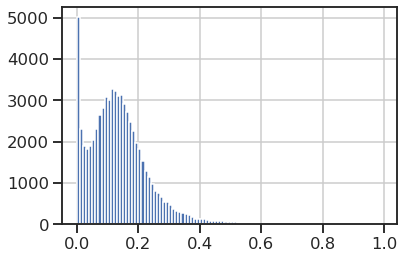

In [175]:
pd.concat(list(proto_to_rel_dists.values())).groupby('Column').min().fingerprint_dist.hist(bins=np.arange(0,1,0.01))

In [166]:
dist_cutoff = 0.01
print(f"Fingerprint distance cutoff: {dist_cutoff}")
# for each structure, first see if it already matches a known prototype. If so, we shouldn't consider it for a new prototype
rel_matched_proto = set()
for comp_type, df in proto_to_rel_dists.items():
    df = df[df.fingerprint_dist < dist_cutoff]
    rel_matched_proto |= (set(df['Column'].values))
print(f"{len(rel_matched_proto)} relaxed structures match a prototye")

# now perform the clustering
all_clusters = {}
structure_indexes = {}
for comp_type, df in tqdm(rel_dists.items()):
#     df = df[df.fingerprint_dist < dist_cutoff]
    df = df[(~df.Row.isin(rel_matched_proto) & ~df.Column.isin(rel_matched_proto))]
    dist_mat = df.pivot(index='Row', columns='Column', values='fingerprint_dist')
    # fill the other side of the matrix, since we just kept the upper triangle before
    dist_mat = dist_mat.combine_first(dist_mat.T)
    dist_mat.replace(np.nan, 1, inplace=True)
    cluster = AgglomerativeClustering(affinity='precomputed',
                                      distance_threshold=dist_cutoff, 
                                      n_clusters=None, 
                                      linkage='complete'
                                     )
    clusters = cluster.fit_predict(dist_mat)
    # also store the indexes
    structure_indexes[comp_type] = list(dist_mat.index)
    all_clusters[comp_type] = clusters
# df.head(2)

Fingerprint distance cutoff: 0.01
5014 relaxed structures match a prototye


  0%|          | 0/64 [00:00<?, ?it/s]

In [182]:
# dist_cutoff = 0.01
for dist_cutoff in [0.01, 0.05, 0.1]:
    print(f"Fingerprint distance cutoff: {dist_cutoff}")
    # for each structure, first see if it already matches a known prototype. If so, we shouldn't consider it for a new prototype
    rel_matched_proto = set()
    for comp_type, df in proto_to_rel_dists.items():
        df = df[df.fingerprint_dist < dist_cutoff]
        rel_matched_proto |= (set(df['Column'].values))
    print(f"{len(rel_matched_proto)} relaxed structures match a prototye")

Fingerprint distance cutoff: 0.01
5014 relaxed structures match a prototye
Fingerprint distance cutoff: 0.05
12923 relaxed structures match a prototye
Fingerprint distance cutoff: 0.1
25818 relaxed structures match a prototye


Text(0.5, 1.0, 'Cluster sizes for fingerprint distance cutoff: 0.01')

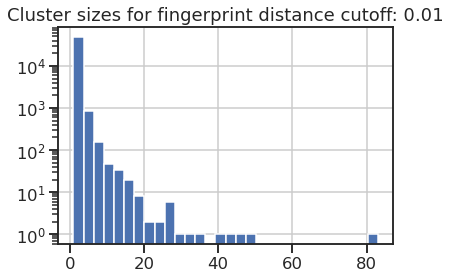

In [167]:
# make a histogram of all cluster sizes
all_sizes = []
for comp_type, clusters in all_clusters.items():
    S = pd.Series(clusters)
    sizes = S.value_counts()
    all_sizes.append(sizes)
all_sizes = pd.concat(all_sizes)
    
ax = all_sizes.hist(bins=30)
ax.set_yscale('log')
ax.set_title(f"Cluster sizes for fingerprint distance cutoff: {dist_cutoff}")

In [178]:
from collections import defaultdict

In [180]:
print(f"{len(all_sizes)} total clusters for fingerprint distance cutoff: {dist_cutoff}")
print()
print("size_cutoff\tnum_clusters\tnum_comp_types_with_clust")
# get some statistics: 
clust_size_cutoffs = [1, 2, 3, 5, 10, 20, 50]
for cutoff in clust_size_cutoffs:
    num_gt_cutoff = 0
    num_comp_types_with_a_clust = 0
    for comp_type, clusters in all_clusters.items():
#         S = pd.Series(clusters)
#         sizes = S.value_counts()
        clusters_by_idx = defaultdict(set)
        for idx, clust in enumerate(clusters):
            clusters_by_idx[clust].add(structure_indexes[comp_type][idx])
        for clust, structure
    
#         num_gt_cutoff += len(sizes[sizes >= cutoff])
#         if len(sizes[sizes >= cutoff]) > 0:
#             num_comp_types_with_a_clust += 1
# #     print(f"{num_comp_types_with_a_clust} have a cluster with size >= {cutoff}")
#     print(f"{cutoff}\t{num_gt_cutoff}\t{num_comp_types_with_a_clust}")

50313 total clusters for fingerprint distance cutoff: 0.01

size_cutoff	num_clusters	num_comp_types_with_clust


Text(0.5, 1.0, 'Cluster sizes for fingerprint distance cutoff: 0.05')

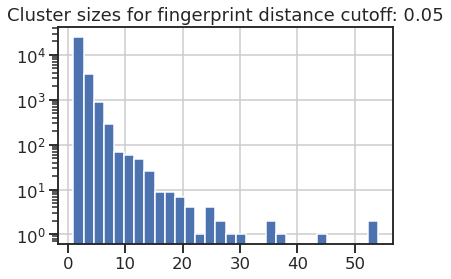

In [161]:
# make a histogram of all cluster sizes
all_sizes = []
for comp_type, clusters in all_clusters.items():
    S = pd.Series(clusters)
    sizes = S.value_counts()
    all_sizes.append(sizes)
all_sizes = pd.concat(all_sizes)
    
ax = all_sizes.hist(bins=30)
ax.set_yscale('log')
ax.set_title(f"Cluster sizes for fingerprint distance cutoff: {dist_cutoff}")

In [162]:
print(f"{len(all_sizes)} total clusters for fingerprint distance cutoff: {dist_cutoff}")
print()
print("size_cutoff\tnum_clusters\tnum_comp_types_with_clust")
# get some statistics: 
clust_size_cutoffs = [1, 2, 3, 5, 10, 20, 50]
for cutoff in clust_size_cutoffs:
    num_gt_cutoff = 0
    num_comp_types_with_a_clust = 0
    for comp_type, clusters in all_clusters.items():
        S = pd.Series(clusters)
        sizes = S.value_counts()
        num_gt_cutoff += len(sizes[sizes >= cutoff])
        if len(sizes[sizes >= cutoff]) > 0:
            num_comp_types_with_a_clust += 1
#     print(f"{num_comp_types_with_a_clust} have a cluster with size >= {cutoff}")
    print(f"{cutoff}\t{num_gt_cutoff}\t{num_comp_types_with_a_clust}")

30622 total clusters for fingerprint distance cutoff: 0.05

size_cutoff	num_clusters	num_comp_types_with_clust
1	30622	64
2	12110	64
3	5144	63
5	1420	53
10	176	28
20	21	9
50	2	2


Text(0.5, 1.0, 'Cluster sizes for fingerprint distance cutoff: 0.1')

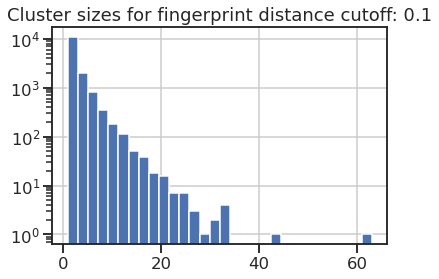

In [164]:
# make a histogram of all cluster sizes
all_sizes = []
for comp_type, clusters in all_clusters.items():
    S = pd.Series(clusters)
    sizes = S.value_counts()
    all_sizes.append(sizes)
all_sizes = pd.concat(all_sizes)
    
ax = all_sizes.hist(bins=30)
ax.set_yscale('log')
ax.set_title(f"Cluster sizes for fingerprint distance cutoff: {dist_cutoff}")

In [165]:
print(f"{len(all_sizes)} total clusters for fingerprint distance cutoff: {dist_cutoff}")
print()
print("size_cutoff\tnum_clusters\tnum_comp_types_with_clust")
# get some statistics: 
clust_size_cutoffs = [1, 2, 3, 5, 10, 20, 50]
for cutoff in clust_size_cutoffs:
    num_gt_cutoff = 0
    num_comp_types_with_a_clust = 0
    for comp_type, clusters in all_clusters.items():
        S = pd.Series(clusters)
        sizes = S.value_counts()
        num_gt_cutoff += len(sizes[sizes >= cutoff])
        if len(sizes[sizes >= cutoff]) > 0:
            num_comp_types_with_a_clust += 1
#     print(f"{num_comp_types_with_a_clust} have a cluster with size >= {cutoff}")
    print(f"{cutoff}\t{num_gt_cutoff}\t{num_comp_types_with_a_clust}")

14680 total clusters for fingerprint distance cutoff: 0.1

size_cutoff	num_clusters	num_comp_types_with_clust
1	14680	64
2	9397	64
3	5716	64
5	2405	63
10	441	45
20	42	16
50	1	1
